In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
data = 'CreditScoring.csv'
df = pd.read_csv(data)

In [7]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [8]:
df.columns = df.columns.str.lower()

In [9]:
status_values = {
    1: "ok", 
    2: 'default', 
    0: 'unk'
}

df.status = df.status.map(status_values)

In [10]:
home_values = {
    1: 'rent', 
    2: 'owner',
    3: 'private',
    4: 'ignore', 
    5: 'parents', 
    6: 'other', 
    0: 'unk'
}

marital_values = {
    1: 'single', 
    2: 'married', 
    3: 'widow', 
    4: 'separated', 
    5: 'divorced', 
    0: 'unk'
}

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

job_values = {
    1: 'fixed', 
    2: 'partime',
    3: 'freelance',
    4: 'others', 
    0: 'unk'
}

In [11]:
df.home = df.home.map(home_values)
df.marital = df.marital.map(marital_values)
df.records = df.records.map(records_values)
df.job = df.job.map(job_values)

In [23]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [24]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [25]:
df.income.max()

np.int64(99999999)

In [26]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value= np.nan)

In [27]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [16]:
del df_train['status']
del df_val['status']
del df_test['status']

## Decision trees

- Training a decision tree
- overfitting
- Controlling the size of a tree

In [33]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'partime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [34]:
xi = df_train.iloc[0].to_dict()

In [35]:
assess_risk(xi)

'ok'

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [20]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [21]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [22]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [23]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [41]:
y_pred = dt.predict_proba(X_val)[:,1]

In [42]:
roc_auc_score(y_val, y_pred)

0.661518248528735

In [43]:
y_pred = dt.predict_proba(X_train)[:,1]
roc_auc_score(y_train, y_pred)

1.0

In [44]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [45]:
y_pred = dt.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train, y_pred)
print('train', auc)

y_pred = dt.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred)
print('validation', auc)

train 0.7761016984958594
validation 0.7389079944782155


In [46]:
from sklearn.tree import export_text

In [48]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- class: 1
|   |   |--- income >  103.50
|   |   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- assets <= 8750.00
|   |   |   |--- class: 1
|   |   |--- assets >  8750.00
|   |   |   |--- class: 0



## Decision tree learning algorithm

- Finding the best split for one column
- Finding the best split for the entire dataset
- Stopping criteria
- learning algorithm

In [50]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [51]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
4,5000,ok
3,5000,ok
0,8000,default
6,9000,ok


In [52]:
Ts = [2000,3000, 4000, 5000, 8000]

In [57]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]

    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))
    print()

2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64



In [58]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000, 500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [59]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
3,5000,1000,ok
2,0,1000,default
5,4000,1000,ok
4,5000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [60]:
thresholds  = {
    'assets': [0, 2000,3000, 4000, 5000, 8000],
    'debt': [500,1000, 2000]
}

In [61]:
for feature, Ts in thresholds.items():
    print("###################")
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]
    
        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))
        print()

###################
assets
0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

###################
debt
500


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64



## Decision Tree Parameter Tuning

- max_depth: control the size of the tree
- min_samples_leaf: control the size of a leaf. leaf is the node when we actually make a decision.


In [24]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)

    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)

    print('%4s -> %.3f' % (d, auc))

   1 -> 0.613
   2 -> 0.688
   3 -> 0.754
   4 -> 0.769
   5 -> 0.765
   6 -> 0.747
  10 -> 0.668
  15 -> 0.644
  20 -> 0.642
None -> 0.650


In [34]:
scores = []

for d in [3, 4, 5, 6, 7, 10, 15, 20 , None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
    
        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((d, s, auc))

In [35]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,min_samples_leaf,auc
0,3.0,1,0.753931
1,3.0,2,0.753931
2,3.0,5,0.753931
3,3.0,10,0.753931
4,3.0,15,0.753931


In [36]:
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
32,6.0,20,0.794667
30,6.0,10,0.789936
31,6.0,15,0.789868
29,6.0,5,0.786876
33,6.0,100,0.780974


In [37]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values='auc')
df_scores_pivot.round(3)

max_depth,NaN,3.0,4.0,5.0,6.0,7.0,10.0,15.0,20.0
min_samples_leaf,,,,,,,,,
1,0.644,0.754,0.769,0.769,0.740,0.741,0.659,0.650,0.648
2,0.669,0.754,0.769,0.747,0.759,0.732,0.680,0.664,0.663
5,0.738,0.754,0.769,0.774,0.787,0.771,0.756,0.742,0.747
10,0.769,0.754,0.764,0.764,0.790,0.781,0.768,0.770,0.770
15,0.758,0.754,0.762,0.762,0.790,0.780,0.765,0.758,0.759
20,0.771,0.754,0.768,0.768,0.795,0.779,0.773,0.771,0.770
100,0.778,0.746,0.758,0.771,0.781,0.779,0.778,0.778,0.778
200,0.773,0.744,0.757,0.770,0.773,0.773,0.773,0.773,0.773
500,0.666,0.666,0.666,0.666,0.666,0.666,0.666,0.666,0.666


<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>

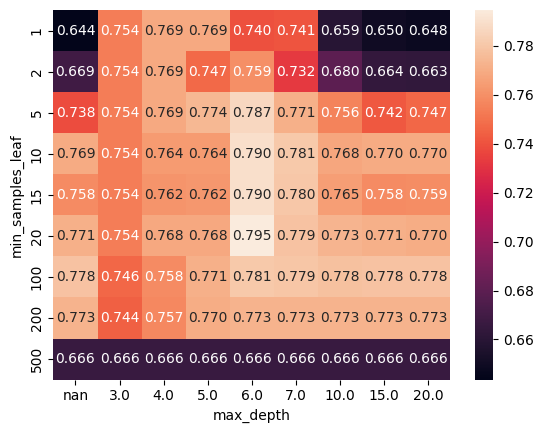

In [38]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [40]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## Ensembles and random forest
- Board of experts
- Ensembling models
- Random forest - ensembling decision trees
- Tuning random forest

Random forest rely on multiple decision trees vates to make desicion. Take average of all probability. Each model gets a random subset of features

In [41]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [52]:
y_pred = rf.predict_proba(X_val)[:,1]

roc_auc_score(y_val, y_pred)

0.7946606262129322

In [59]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)

    scores.append((n, auc))

In [60]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

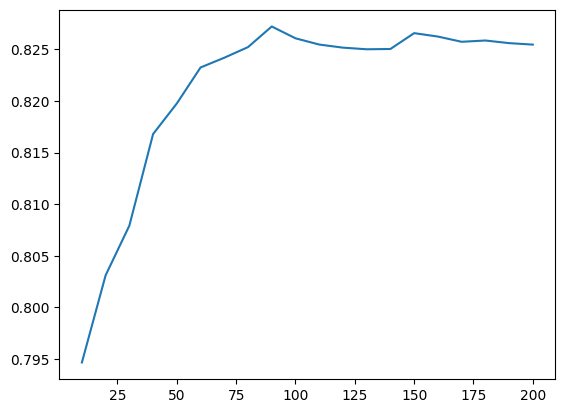

In [61]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [63]:
scores = []


for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((d, n, auc))

In [64]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'auc'])

In [65]:
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.813131
1,5,20,0.816923
2,5,30,0.814349
3,5,40,0.815588
4,5,50,0.818363


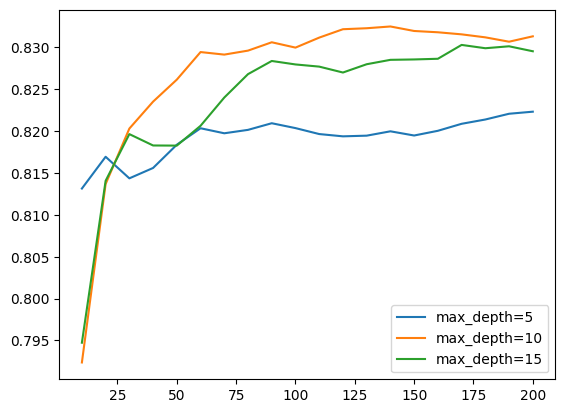

In [67]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]

    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%d' % d)

plt.legend()

In [68]:
max_depth = 10

In [69]:
scores = []


for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
    
        scores.append((s, n, auc))

In [72]:
df_scores = pd.DataFrame(scores, columns=['min_samples_leaf',
                                          'n_estimators',
                                          'auc'])
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.792377
1,1,20,0.813669
2,1,30,0.820288
3,1,40,0.823502
4,1,50,0.826129


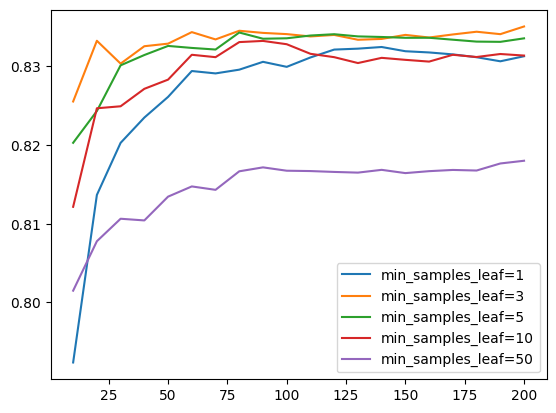

In [73]:
for s in [1, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]

    plt.plot(df_subset.n_estimators, df_subset.auc, label='min_samples_leaf=%d' % s)

plt.legend()

In [74]:
min_samples_leaf = 3

In [75]:
rf = RandomForestClassifier(n_estimators=n,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Gradient boosting and XGBoost

- Gradient boosting vs random forest
- installing xgboost
- performance monitoring
- Parsing xgboost's monitoring output

In [76]:
!pip install xgboost


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [77]:
import xgboost as xgb

In [83]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [89]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6, 
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [90]:
y_pred = model.predict(dval)

In [91]:
roc_auc_score(y_val, y_pred)

0.8162956278816798

In [92]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [95]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6, 
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  verbose_eval=5,
                  num_boost_round=200)

In [98]:
s = output.stdout
s.split('\n')

['[0]\ttrain-auc:0.86025\tval-auc:0.77680',
 '[5]\ttrain-auc:0.92413\tval-auc:0.81143',
 '[10]\ttrain-auc:0.94750\tval-auc:0.81527',
 '[15]\ttrain-auc:0.96043\tval-auc:0.81455',
 '[20]\ttrain-auc:0.97053\tval-auc:0.81532',
 '[25]\ttrain-auc:0.97799\tval-auc:0.81193',
 '[30]\ttrain-auc:0.98296\tval-auc:0.81090',
 '[35]\ttrain-auc:0.98889\tval-auc:0.81290',
 '[40]\ttrain-auc:0.99059\tval-auc:0.81398',
 '[45]\ttrain-auc:0.99484\tval-auc:0.80869',
 '[50]\ttrain-auc:0.99660\tval-auc:0.80868',
 '[55]\ttrain-auc:0.99807\tval-auc:0.80769',
 '[60]\ttrain-auc:0.99855\tval-auc:0.80680',
 '[65]\ttrain-auc:0.99909\tval-auc:0.80604',
 '[70]\ttrain-auc:0.99926\tval-auc:0.80610',
 '[75]\ttrain-auc:0.99955\tval-auc:0.80592',
 '[80]\ttrain-auc:0.99968\tval-auc:0.80545',
 '[85]\ttrain-auc:0.99979\tval-auc:0.80727',
 '[90]\ttrain-auc:0.99982\tval-auc:0.80770',
 '[95]\ttrain-auc:0.99987\tval-auc:0.80727',
 '[100]\ttrain-auc:0.99990\tval-auc:0.80718',
 '[105]\ttrain-auc:0.99995\tval-auc:0.80605',
 '[110]\tt

In [100]:
line = s.split('\n')[0]
num_iter, train_auc, val_auc = line.split('\t')

In [102]:
int(num_iter.strip('[]'))

0

In [103]:
float(train_auc.split(':')[1])

0.86025

In [104]:
float(val_auc.split(':')[1])

0.7768

In [106]:
def parse_xgb_output(output):
    results = []
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))

    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [108]:
df_score = parse_xgb_output(output)

In [109]:
df_score.head()

,num_iter,train_auc,val_auc
0,0,0.86025,0.77680
1,5,0.92413,0.81143
2,10,0.94750,0.81527
3,15,0.96043,0.81455
4,20,0.97053,0.81532


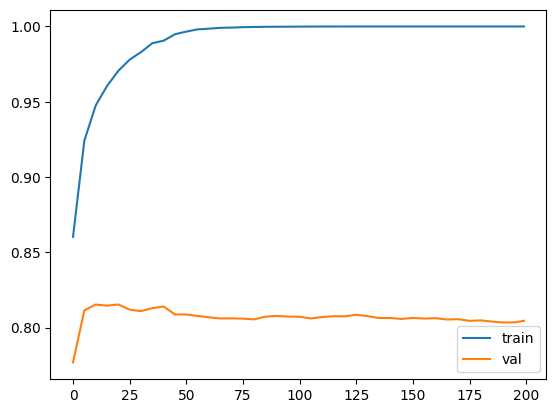

In [110]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

## XGBoost Parameter Tuning

- eta
- max_depth
- min_child_weight -> equivalent to min_samples_leaf in decision tree?

In [114]:
scores = {}

In [124]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6, 
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  verbose_eval=5,
                  num_boost_round=200)

In [125]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

In [126]:
scores

{'eta=0.3':     num_iter  train_auc  val_auc
 0          0    0.86025  0.77680
 1          5    0.92413  0.81143
 2         10    0.94750  0.81527
 3         15    0.96043  0.81455
 4         20    0.97053  0.81532
 5         25    0.97799  0.81193
 6         30    0.98296  0.81090
 7         35    0.98889  0.81290
 8         40    0.99059  0.81398
 9         45    0.99484  0.80869
 10        50    0.99660  0.80868
 11        55    0.99807  0.80769
 12        60    0.99855  0.80680
 13        65    0.99909  0.80604
 14        70    0.99926  0.80610
 15        75    0.99955  0.80592
 16        80    0.99968  0.80545
 17        85    0.99979  0.80727
 18        90    0.99982  0.80770
 19        95    0.99987  0.80727
 20       100    0.99990  0.80718
 21       105    0.99995  0.80605
 22       110    0.99997  0.80700
 23       115    0.99998  0.80752
 24       120    0.99999  0.80746
 25       125    1.00000  0.80851
 26       130    1.00000  0.80758
 27       135    1.00000  0.80634
 28

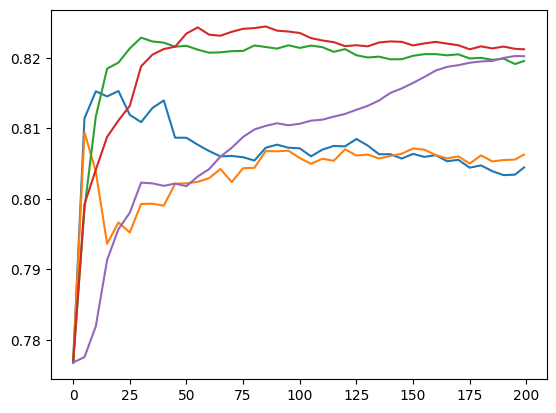

In [128]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)

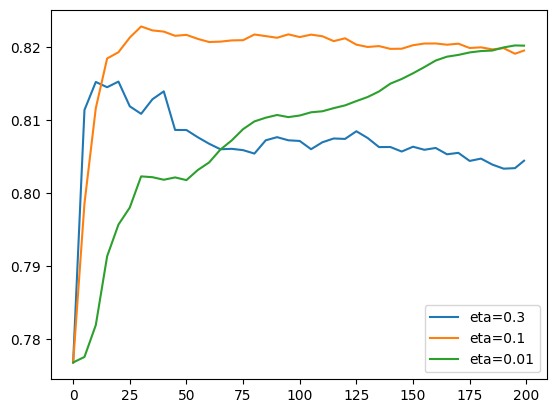

In [130]:
etas = ['eta=0.3', 'eta=0.1', 'eta=0.01']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()

In [131]:
scores = {}

In [138]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10, 
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  verbose_eval=5,
                  num_boost_round=200)

In [139]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

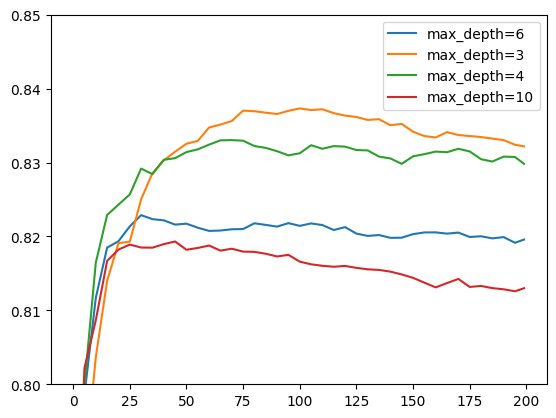

In [141]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
plt.ylim(0.8, 0.85)
plt.legend()

In [142]:
scores = {}

In [147]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3, 
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  verbose_eval=5,
                  num_boost_round=200)

In [148]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

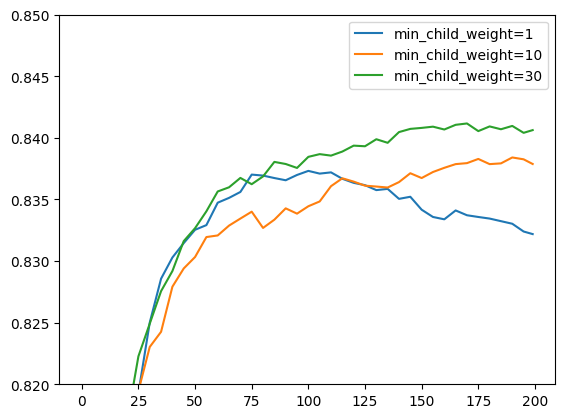

In [150]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
plt.ylim(0.82, 0.85)
plt.legend()

In [151]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3, 
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  verbose_eval=5,
                  num_boost_round=175)

[0]	train-auc:0.76558	val-auc:0.75163
[5]	train-auc:0.81402	val-auc:0.78776
[10]	train-auc:0.83668	val-auc:0.80365
[15]	train-auc:0.85093	val-auc:0.81399
[20]	train-auc:0.86127	val-auc:0.81909
[25]	train-auc:0.86782	val-auc:0.81930
[30]	train-auc:0.87569	val-auc:0.82501
[35]	train-auc:0.88118	val-auc:0.82857
[40]	train-auc:0.88541	val-auc:0.83029
[45]	train-auc:0.88922	val-auc:0.83146
[50]	train-auc:0.89227	val-auc:0.83254
[55]	train-auc:0.89560	val-auc:0.83292
[60]	train-auc:0.89815	val-auc:0.83474
[65]	train-auc:0.90015	val-auc:0.83513
[70]	train-auc:0.90172	val-auc:0.83561
[75]	train-auc:0.90401	val-auc:0.83702
[80]	train-auc:0.90554	val-auc:0.83694
[85]	train-auc:0.90748	val-auc:0.83674
[90]	train-auc:0.90883	val-auc:0.83656
[95]	train-auc:0.91064	val-auc:0.83699
[100]	train-auc:0.91283	val-auc:0.83732
[105]	train-auc:0.91410	val-auc:0.83710
[110]	train-auc:0.91526	val-auc:0.83720
[115]	train-auc:0.91687	val-auc:0.83668
[120]	train-auc:0.91778	val-auc:0.83635
[125]	train-auc:0.9189

Other parameter: https://xgboost.readthedocs.io/en/stable/parameter.html

Useful ones:
- `subsample` and `colsample_bytree`
- `lambda` and `alpha`

## Selecting the final model

- Choosing between xgboost, random forest and decision tree
- Training the final model
- Saving the model

In [152]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [156]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7901210150928937

In [154]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [157]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8350783075192525

In [155]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3, 
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  verbose_eval=5,
                  num_boost_round=175)

[0]	train-auc:0.76558	val-auc:0.75163
[5]	train-auc:0.81402	val-auc:0.78776
[10]	train-auc:0.83668	val-auc:0.80365
[15]	train-auc:0.85093	val-auc:0.81399
[20]	train-auc:0.86127	val-auc:0.81909
[25]	train-auc:0.86782	val-auc:0.81930
[30]	train-auc:0.87569	val-auc:0.82501
[35]	train-auc:0.88118	val-auc:0.82857
[40]	train-auc:0.88541	val-auc:0.83029
[45]	train-auc:0.88922	val-auc:0.83146
[50]	train-auc:0.89227	val-auc:0.83254
[55]	train-auc:0.89560	val-auc:0.83292
[60]	train-auc:0.89815	val-auc:0.83474
[65]	train-auc:0.90015	val-auc:0.83513
[70]	train-auc:0.90172	val-auc:0.83561
[75]	train-auc:0.90401	val-auc:0.83702
[80]	train-auc:0.90554	val-auc:0.83694
[85]	train-auc:0.90748	val-auc:0.83674
[90]	train-auc:0.90883	val-auc:0.83656
[95]	train-auc:0.91064	val-auc:0.83699
[100]	train-auc:0.91283	val-auc:0.83732
[105]	train-auc:0.91410	val-auc:0.83710
[110]	train-auc:0.91526	val-auc:0.83720
[115]	train-auc:0.91687	val-auc:0.83668
[120]	train-auc:0.91778	val-auc:0.83635
[125]	train-auc:0.9189

In [158]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8337062262821542

In [160]:
# train final model

df_full_train = df_full_train.reset_index(drop=True)
y_full_train = (df_full_train.status == 'default').astype(int).values

del df_full_train['status']

In [161]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [162]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_full_train, y_full_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [164]:
y_pred = rf.predict_proba(X_test)[:, 1]

In [165]:
roc_auc_score(y_test, y_pred)

0.8305741163532915